In [ ]:
!pip install --upgrade numpy
!pip install --upgrade scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 96.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 15.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    U

In [1]:
# 🛠️ SETUP
!pip install PyPDF2 pandas nltk spacy gensim scikit-learn matplotlib seaborn -q
import nltk
nltk.download('stopwords')
!python -m spacy download en_core_web_sm
!pip install pyLDAvis


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 71.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.5 MB/s eta 0:00:00


In [1]:
# 📚 IMPORTS
import os
import re
import PyPDF2
import pandas as pd
import nltk
from nltk.corpus import stopwords
from gensim import corpora, models
import spacy
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models


# 🔧 INIT
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")


In [26]:
from google.colab import files
uploaded = files.upload()

Saving ALL_metadata.xlsx to ALL_metadata (1).xlsx


In [4]:
# Unzip the uploaded zip file (replace with your zip name)
!unzip ENG_PDF.zip -d gdpr_pdfs

Archive:  ENG_PDF.zip
  inflating: gdpr_pdfs/ETid-570.pdf  
  inflating: gdpr_pdfs/ETid-689.pdf  
  inflating: gdpr_pdfs/ETid-752.pdf  
  inflating: gdpr_pdfs/ETid-820.pdf  
  inflating: gdpr_pdfs/ETid-847.pdf  
  inflating: gdpr_pdfs/ETid-875.pdf  
  inflating: gdpr_pdfs/ETid-893.pdf  
  inflating: gdpr_pdfs/ETid-930.pdf  
  inflating: gdpr_pdfs/ETid-987.pdf  
  inflating: gdpr_pdfs/ETid-1009.pdf  
  inflating: gdpr_pdfs/ETid-1188.pdf  
  inflating: gdpr_pdfs/ETid-1190.pdf  
  inflating: gdpr_pdfs/ETid-1250.pdf  
  inflating: gdpr_pdfs/ETid-1352.pdf  
  inflating: gdpr_pdfs/ETid-1373.pdf  
  inflating: gdpr_pdfs/ETid-1422.pdf  
  inflating: gdpr_pdfs/ETid-1461.pdf  
  inflating: gdpr_pdfs/ETid-1543.pdf  
  inflating: gdpr_pdfs/ETid-1564.pdf  
  inflating: gdpr_pdfs/ETid-1578.pdf  
  inflating: gdpr_pdfs/ETid-1666.pdf  
  inflating: gdpr_pdfs/ETid-1677.pdf  
  inflating: gdpr_pdfs/ETid-1696.pdf  
  inflating: gdpr_pdfs/ETid-1844.pdf  
  inflating: gdpr_pdfs/ETid-1910.pdf  
  inflating:

In [5]:
# 📥 1. Extract text from PDFs
def extract_text_from_pdfs(pdf_dir):
    texts = {}
    for filename in os.listdir(pdf_dir):
        if filename.endswith('.pdf'):
            with open(os.path.join(pdf_dir, filename), 'rb') as f:
                reader = PyPDF2.PdfReader(f)
                text = " ".join(page.extract_text() for page in reader.pages)
                texts[filename] = text
    return texts

# Replace with your path
pdf_dir = 'gdpr_pdfs'  # Adjust if needed
texts = extract_text_from_pdfs(pdf_dir)
print(f"Extracted {len(texts)} PDF(s). Sample:\n{list(texts.keys())[:2]}")


[0, IndirectObject(1451, 0, 133166858761360)]
[0, IndirectObject(1421, 0, 133166858761360)]
[0, IndirectObject(1394, 0, 133166858761360)]
[0, IndirectObject(1355, 0, 133166858761360)]
[0, IndirectObject(1188, 0, 133166858761360)]
[0, IndirectObject(1183, 0, 133166858761360)]
[0, IndirectObject(1178, 0, 133166858761360)]
[0, IndirectObject(1205, 0, 133166858761360)]
[0, IndirectObject(3994, 0, 133166758887632)]
[0, IndirectObject(3989, 0, 133166758887632)]
[0, IndirectObject(3984, 0, 133166758887632)]
[0, IndirectObject(3979, 0, 133166758887632)]
[0, IndirectObject(3974, 0, 133166758887632)]
[0, IndirectObject(3969, 0, 133166758887632)]
[0, IndirectObject(3935, 0, 133166758887632)]
[0, IndirectObject(3930, 0, 133166758887632)]
[0, IndirectObject(3925, 0, 133166758887632)]
[0, IndirectObject(3920, 0, 133166758887632)]
[0, IndirectObject(3915, 0, 133166758887632)]
[0, IndirectObject(3889, 0, 133166758887632)]
[0, IndirectObject(3884, 0, 133166758887632)]
[0, IndirectObject(3879, 0, 133166

Extracted 37 PDF(s). Sample:
['ETid-2317.pdf', 'ETid-893.pdf']


In [27]:
df_meta=pd.read_excel('ALL_metadata.xlsx')
df_meta.head()

,Unnamed: 0,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Source1,Source2
0,NaN,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting","Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art...",Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",link,https://www.enforcementtracker.com/ETid-2566 (...
1,NaN,ETid-2561,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,link link,https://www.enforcementtracker.com/ETid-2561 (...
2,NaN,ETid-2555,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,link link,https://www.enforcementtracker.com/ETid-2555 (...
3,NaN,ETid-2317,UNITED KINGDOM,Information Commissioner (ICO),2024-04-30 00:00:00,8700,Central Young Men’s Christian Association,Individuals and Private Associations,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Central Young M...,link link,https://www.enforcementtracker.com/ETid-2317 (...
4,NaN,ETid-2170,UNITED KINGDOM,Information Commissioner (ICO),2023-12-13 00:00:00,400000,UK Ministry of Defense,Public Sector and Education,Unknown,Insufficient technical and organisational meas...,The UK DPA has fined the Ministry of Defense E...,link,https://www.enforcementtracker.com/ETid-2170 (...


In [28]:
# prompt: help me filter the df_meta usiing the filename from texts on column Etid and replace the .pdf from filenames

def filter_and_replace(df, texts):
    """Filters the DataFrame based on filenames in 'texts' and replaces .pdf."""

    # Extract filenames without .pdf extension from the texts dictionary keys
    filenames_no_pdf = [filename[:-4] for filename in texts.keys()]

    # Filter the DataFrame to include only rows where 'Etid' is in the filenames
    df_filtered = df[df['ETid'].isin(filenames_no_pdf)]

    return df_filtered

# Apply the function
df_meta = filter_and_replace(df_meta, texts)

# Display the filtered DataFrame (optional)
df_meta.head()


,Unnamed: 0,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Source1,Source2
0,NaN,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting","Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art...",Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",link,https://www.enforcementtracker.com/ETid-2566 (...
1,NaN,ETid-2561,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,link link,https://www.enforcementtracker.com/ETid-2561 (...
2,NaN,ETid-2555,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,link link,https://www.enforcementtracker.com/ETid-2555 (...
3,NaN,ETid-2317,UNITED KINGDOM,Information Commissioner (ICO),2024-04-30 00:00:00,8700,Central Young Men’s Christian Association,Individuals and Private Associations,"Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Central Young M...,link link,https://www.enforcementtracker.com/ETid-2317 (...
6,NaN,ETid-1461,UNITED KINGDOM,Information Commissioner (ICO),2022-10-19 00:00:00,5033000,Interserve Group Limited,Industry and Commerce,"Art. 5 (1) f) GDPR, Art. 32 GDPR",Insufficient technical and organisational meas...,The British DPA has fined the construction gro...,link link,https://www.enforcementtracker.com/ETid-1461 (...


In [29]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37 entries, 0 to 64
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            0 non-null      float64
 1   ETid                  37 non-null     object 
 2   Country               37 non-null     object 
 3   Authority             37 non-null     object 
 4   Date of Decision      37 non-null     object 
 5   Fine [€]              37 non-null     object 
 6   Controller/Processor  37 non-null     object 
 7   Sector                37 non-null     object 
 8   Quoted Art.           37 non-null     object 
 9   Type                  37 non-null     object 
 10  Summary               37 non-null     object 
 11  Source1               37 non-null     object 
 12  Source2               37 non-null     object 
dtypes: float64(1), object(12)
memory usage: 5.1+ KB


In [30]:
df_meta['Fine [€]'].unique()

array([70300, 3500000, 904000, 8700, 5033000, 1547000, 91000, 9000000,
       115000, 585000, 29000, 1405000, 20450000, 345000000, 22500,
       1200000000, 750000, 15000, 460000, 5500000, 100000, 390000000,
       405000000, 110000, 60000, 1500, 'Only intention to issue fine',
       225000000, 90000, 85000, 70000, 450000, 75000, 2500, 202000, 3250,
       13500], dtype=object)

In [31]:
df_meta['Fine [€]'].replace('Only intention to issue fine', 0, inplace=True)

<ipython-input-31-ed8caeb34281>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta['Fine [€]'].replace('Only intention to issue fine', 0, inplace=True)
<ipython-input-31-ed8caeb34281>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_meta['Fine [€]'].replace('Only intention to issue fine', 0

In [32]:
df_meta['Quoted Art.'].unique()

array(['Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR, Art. 33 (1) GDPR',
       'Art. 32 (1) GDPR', 'Art. 5 (1) f) GDPR, Art. 32 (1), (2) GDPR',
       'Art. 5 (1) f) GDPR, Art. 32 GDPR',
       'Art. 5 (1) a) GDPR, Art. 6 GDPR, Art. 9 GDPR, Art. 13 (1) c) GDPR, Regulation 21 PECR',
       'Art. 5 (1) a), e) GDPR, Art. 6 GDPR, Art. 9 GDPR, Art. 14 GDPR, Art. 15 GDPR, Art. 16 GDPR, Art. 17 GDPR, Art. 21 GDPR, Art. 22 GDPR, Art. 35 GDPR',
       'Art. 5 (1) a) f) GDPR', 'Art. 32 GDPR',
       'Art. 5 (1) c), 5 (1) f) GDPR, Art. 12 (1) GDPR, Art. 13 (1) e) GDPR, Art. 24 (1) GDPR, Art. 25 (1), (2) GDPR',
       'Art. 5 (1) c) GDPR, Art. 6 (1), (4) GDPR, Art. 9 (1) GDPR',
       'Art. 46 (1) GDPR', 'Art. 5 (1) f) GDPR, Art. 32 (1) GDPR',
       'Art. 5 (1) f) GDPR, Art. 5 (2) GDPR, Art. 32 (1) GDPR',
       'Art. 6 (1) GDPR, Art. 12 GDPR, Art. 13 (1) c) GDPR',
       'Art. 5 (1) a) GDPR, Art. 6 (1) GDPR, Art. 12 GDPR, Art. 13 (1) c) GDPR',
       'Art. 5 (1) a), c) GDPR, Art. 6 (1) GDPR, Art. 

In [33]:
# Step 1: Clean metadata - drop 'Unnamed', 'Source1', 'Source2'
metadata_df_cleaned = df_meta.drop(columns=[col for col in df_meta.columns if 'Unnamed' in col or col in ['Source1', 'Source2']])

# Step 2: Normalize 'Quoted Art.' column by splitting and exploding
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].fillna('Unknown')
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].str.replace('Art. ', '', regex=False)
metadata_df_cleaned['Quoted Art.'] = metadata_df_cleaned['Quoted Art.'].str.split(', ')
metadata_exploded = metadata_df_cleaned.explode('Quoted Art.')
metadata_exploded['Quoted Art.'] = 'Art. ' + metadata_exploded['Quoted Art.'].str.strip()

# Step 3: Create a simplified version
# Keep only the base article (e.g., 'Art. 5', 'Art. 6') and remove subpoints like (1), (2), a), b), etc.
metadata_exploded['Quoted Art. Simple'] = metadata_exploded['Quoted Art.'].str.extract(r'(Art\.\s*\d+)')
metadata_exploded = metadata_exploded.dropna()

In [34]:
metadata_exploded.head()

,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,Quoted Art. Simple
0,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",Art. 5
0,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 32 (1),Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",Art. 32
0,ETid-2566,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 33 (1) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",Art. 33
1,ETid-2561,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,Art. 32
2,ETid-2555,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,Art. 5


In [35]:
# Group by simplified article and calculate summary statistics
article_summary = metadata_exploded.groupby('Quoted Art. Simple').agg(
    total_fines=('Fine [€]', 'sum'),
    average_fine=('Fine [€]', 'mean'),
    case_count=('Fine [€]', 'count')
).reset_index().sort_values(by='total_fines', ascending=False)

print(article_summary)

   Quoted Art. Simple  total_fines  average_fine  case_count
17             Art. 5   1731283500  5.770945e+07          30
0             Art. 12   1370626000  1.522918e+08           9
16            Art. 46   1200000000  1.200000e+09           1
1             Art. 13    967159500  1.208949e+08           8
19             Art. 6    811144500  1.158778e+08           7
8             Art. 24    750294500  1.500589e+08           5
9             Art. 25    750292000  1.875730e+08           4
14            Art. 35    414000000  2.070000e+08           2
2             Art. 14    234002500  7.800083e+07           3
11            Art. 32     33819500  1.779974e+06          19
20             Art. 9     10569500  3.523167e+06           3
3             Art. 15      9126000  2.281500e+06           4
7             Art. 22      9000000  9.000000e+06           1
6             Art. 21      9000000  9.000000e+06           1
5             Art. 17      9000000  9.000000e+06           1
4             Art. 16   

<ipython-input-38-4b9d769dd567>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='total_fines', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
<ipython-input-38-4b9d769dd567>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='total_fines', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)


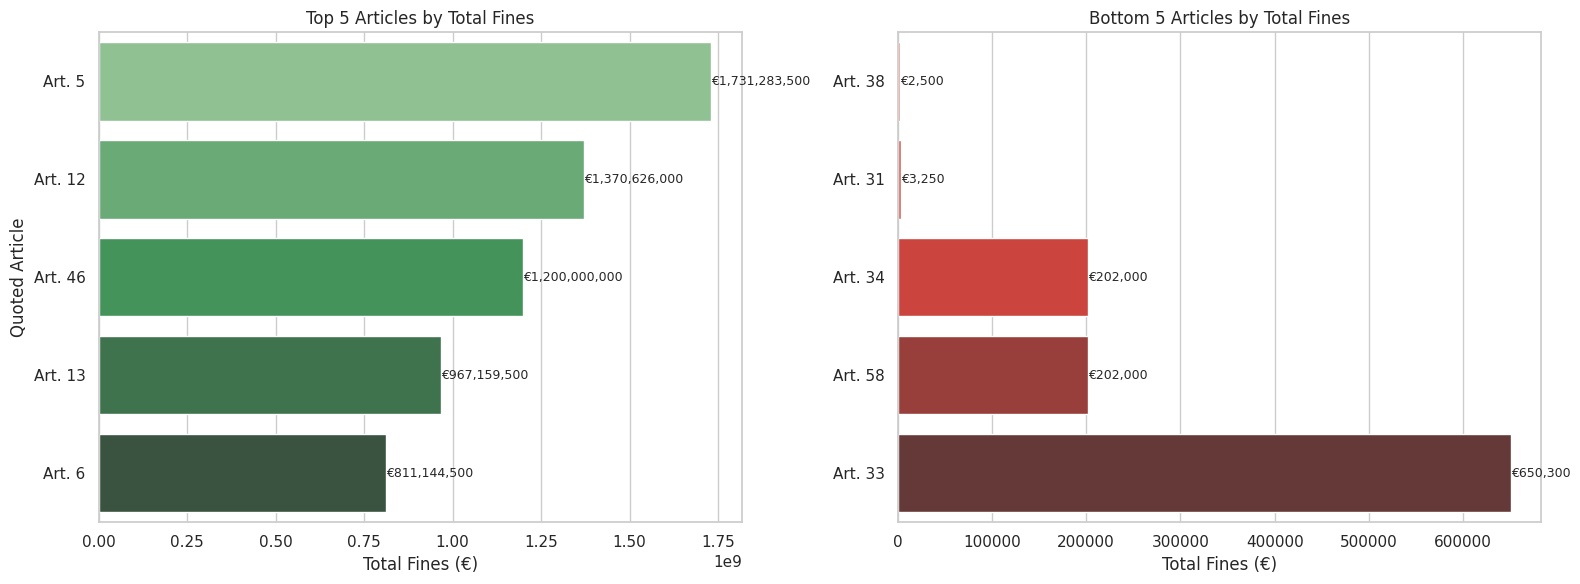

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare top and bottom 5
top5 = article_summary.nlargest(5, 'total_fines')
bottom5 = article_summary.nsmallest(5, 'total_fines')

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5
sns.barplot(data=top5, x='total_fines', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
ax1.set_title('Top 5 Articles by Total Fines')
ax1.set_xlabel('Total Fines (€)')
ax1.set_ylabel('Quoted Article')
for bar, value in zip(ax1.patches, top5['total_fines']):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

# Bottom 5
sns.barplot(data=bottom5, x='total_fines', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)
ax2.set_title('Bottom 5 Articles by Total Fines')
ax2.set_xlabel('Total Fines (€)')
ax2.set_ylabel('')
for bar, value in zip(ax2.patches, bottom5['total_fines']):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


<ipython-input-17-5fba7728d01a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top5, x='average_fine', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
<ipython-input-17-5fba7728d01a>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom5, x='average_fine', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)


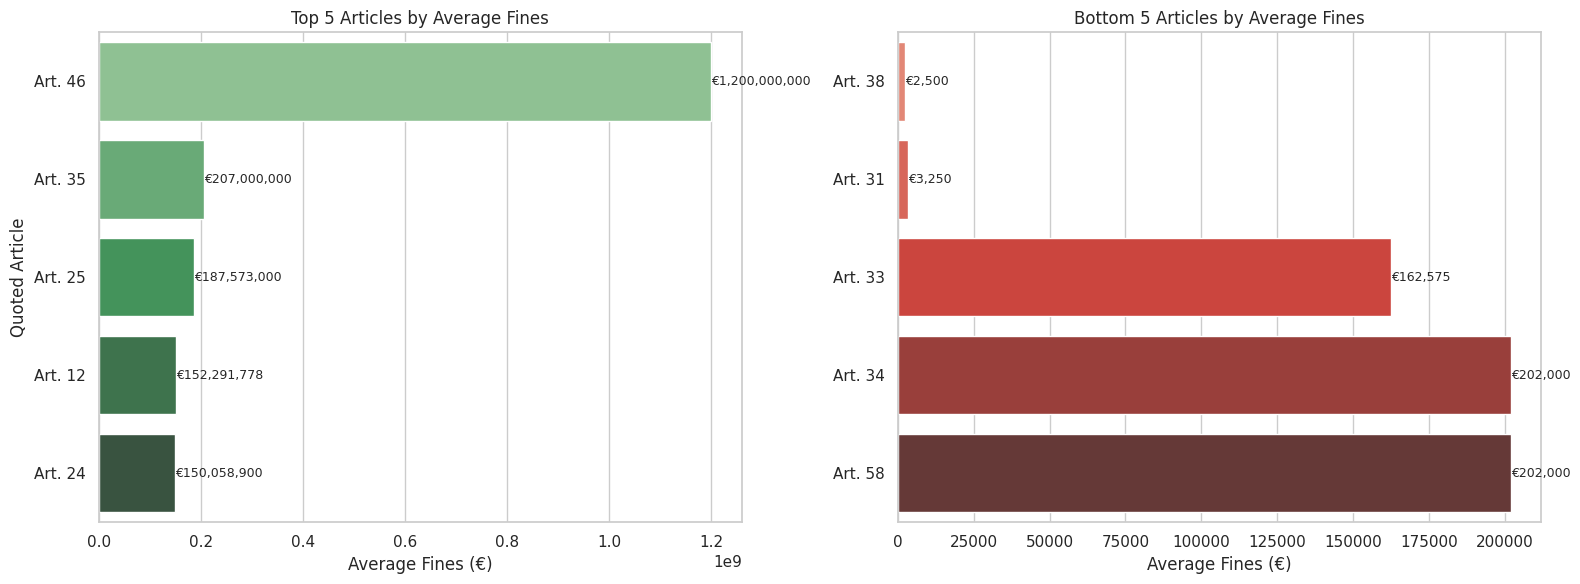

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare top and bottom 5
top5 = article_summary.nlargest(5, 'average_fine')
bottom5 = article_summary.nsmallest(5, 'average_fine')

sns.set(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Top 5
sns.barplot(data=top5, x='average_fine', y='Quoted Art. Simple', palette='Greens_d', ax=ax1)
ax1.set_title('Top 5 Articles by Average Fines')
ax1.set_xlabel('Average Fines (€)')
ax1.set_ylabel('Quoted Article')
for bar, value in zip(ax1.patches, top5['average_fine']):
    ax1.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

# Bottom 5
sns.barplot(data=bottom5, x='average_fine', y='Quoted Art. Simple', palette='Reds_d', ax=ax2)
ax2.set_title('Bottom 5 Articles by Average Fines')
ax2.set_xlabel('Average Fines (€)')
ax2.set_ylabel('')
for bar, value in zip(ax2.patches, bottom5['average_fine']):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f"€{value:,.0f}",
             va='center', ha='left', fontsize=9)

plt.tight_layout()
plt.show()


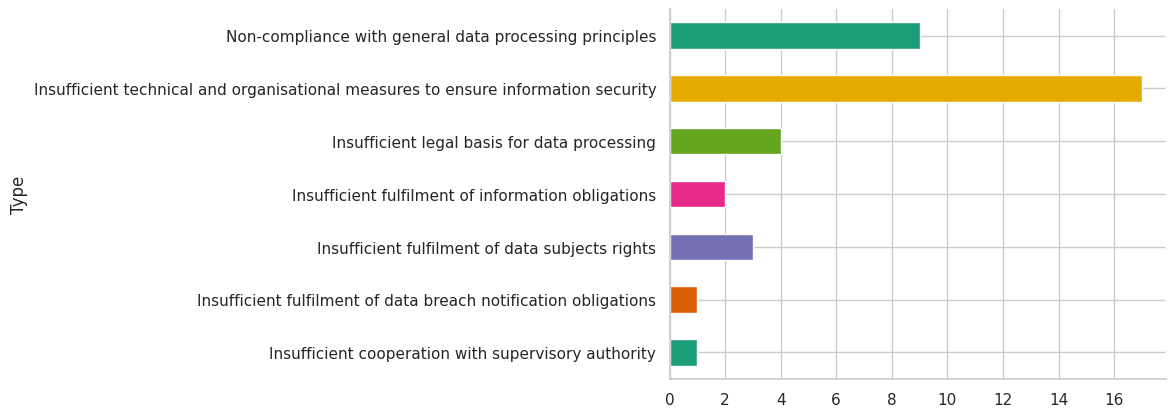

In [18]:
# @title Type

from matplotlib import pyplot as plt
import seaborn as sns
metadata_df_cleaned.groupby('Type').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

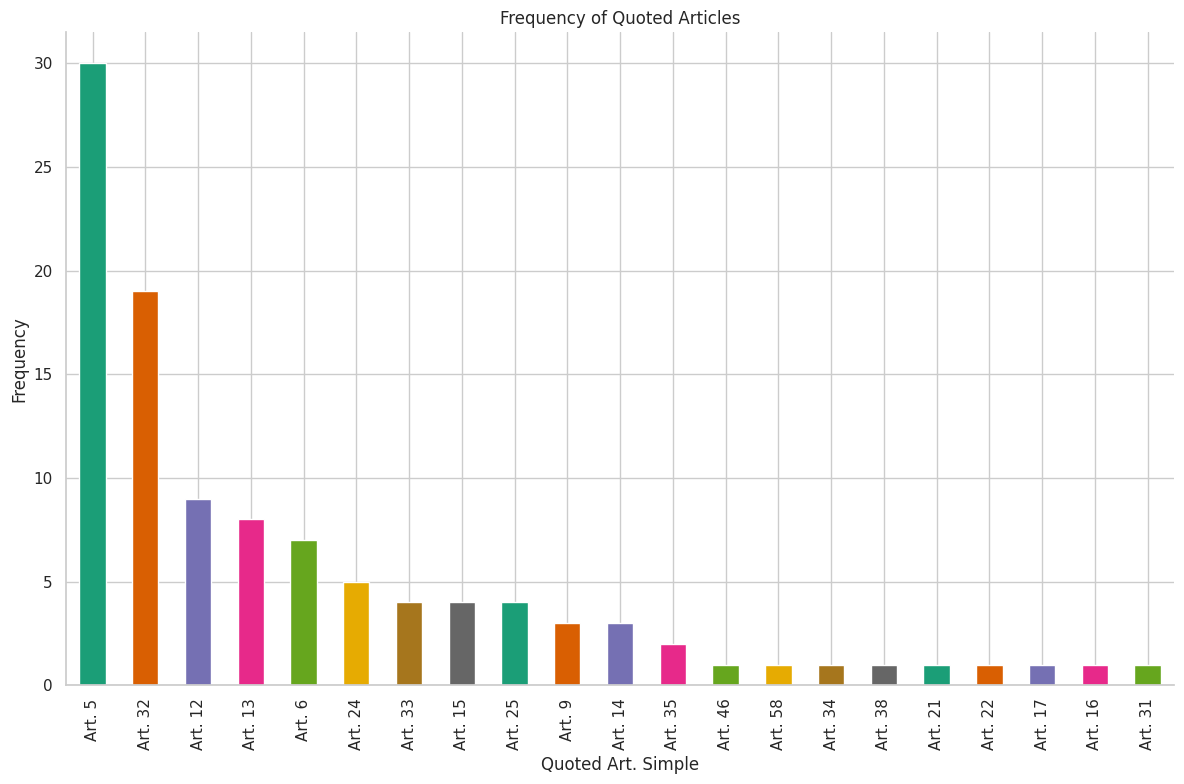

In [19]:
plt.figure(figsize=(12, 8))

# Count the occurrences of each article and plot as bar
article_counts = metadata_exploded['Quoted Art. Simple'].value_counts()

article_counts.plot(
    kind='bar',
    color=sns.color_palette('Dark2')
)

# Add labels and title
plt.title('Frequency of Quoted Articles')
plt.xlabel('Quoted Art. Simple')
plt.ylabel('Frequency')

# Improve readability
plt.xticks(rotation=90)
plt.gca().spines[['top', 'right']].set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
# 🧼 2. Clean text and tokenize
'''
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\n+', ' ', text)
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 3]
    return tokens
'''

In [6]:
def clean_text(text):
    doc = nlp(text.lower())
    tokens = [
        token.lemma_ for token in doc
        if token.is_alpha and not token.is_stop and len(token) > 3
    ]
    return tokens

In [30]:
# 🔎 3. Keyword frequency analysis
def keyword_frequency(text, keywords):
    return {kw: text.lower().count(kw) for kw in keywords}

keywords = ['monitoring', 'encryption', 'access control', 'destruct', 'logging', 'transfer',
            'privacy', 'rights', 'vulnerability', 'child', 'personal data', 'breach', 'risk']

keyword_df = pd.DataFrame(
    [keyword_frequency(text, keywords) for text in texts.values()],
    index=texts.keys()
)
keyword_df.to_csv('keyword_frequency.csv')
keyword_df.style.background_gradient(cmap='Blues')

,monitoring,encryption,access control,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
ETid-2317.pdf,3,1,0,3,0,1,2,6,0,0,35,27,16
ETid-893.pdf,0,0,0,0,0,0,0,0,0,1,5,3,1
ETid-875.pdf,0,0,0,2,0,8,5,34,0,4,132,14,13
ETid-1250.pdf,0,1,0,4,0,1,1,6,0,1,44,16,22
ETid-1009.pdf,155,0,0,4,0,6,24,48,0,0,240,1,22
ETid-1422.pdf,0,0,0,1,0,1,7,5,0,0,32,14,5
ETid-1543.pdf,2,0,0,0,1,3,43,151,3,849,268,12,540
ETid-2566.pdf,0,2,0,3,0,1,3,15,1,15,67,47,47
ETid-847.pdf,0,0,0,0,0,0,0,0,0,0,0,0,0
ETid-570.pdf,3,5,1,4,0,6,10,61,0,44,374,330,187


In [43]:
keywords_df = pd.read_csv('keyword_frequency.csv')

In [44]:
keywords_df.head()

,Unnamed: 0,monitoring,encryption,access control,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
0,ETid-2317.pdf,3,1,0,3,0,1,2,6,0,0,35,27,16
1,ETid-893.pdf,0,0,0,0,0,0,0,0,0,1,5,3,1
2,ETid-875.pdf,0,0,0,2,0,8,5,34,0,4,132,14,13
3,ETid-1250.pdf,0,1,0,4,0,1,1,6,0,1,44,16,22
4,ETid-1009.pdf,155,0,0,4,0,6,24,48,0,0,240,1,22


In [46]:
metadata_exploded['ETid'] = metadata_exploded['ETid'].astype(str).str.strip() + '.pdf'

merged_df = metadata_exploded.merge(keywords_df, left_on='ETid', right_on='Unnamed: 0')

In [47]:
merged_df.head()

,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary,...,destruct,logging,transfer,privacy,rights,vulnerability,child,personal data,breach,risk
0,ETid-2566.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",...,3,0,1,3,15,1,15,67,47,47
1,ETid-2566.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 32 (1),Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",...,3,0,1,3,15,1,15,67,47,47
2,ETid-2566.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-04-14 00:00:00,70300,DPP Law Ltd.,"Finance, Insurance and Consulting",Art. 33 (1) GDPR,Insufficient technical and organisational meas...,"The UK DPA (ICO) has imposed a fine of £ 60,00...",...,3,0,1,3,15,1,15,67,47,47
3,ETid-2561.pdf,UNITED KINGDOM,Information Commissioner (ICO),2025-03-26 00:00:00,3500000,Advanced Computer Software Group Ltd,Health Care,Art. 32 (1) GDPR,Insufficient technical and organisational meas...,The UK DPA (ICO) has fined Advanced Computer S...,...,0,0,0,0,0,0,0,0,0,0
4,ETid-2555.pdf,UNITED KINGDOM,Information Commissioner (ICO),2024-09-26 00:00:00,904000,Police Service of Northern Ireland,Public Sector and Education,Art. 5 (1) f) GDPR,Insufficient technical and organisational meas...,The ICO fined the Police Service of Northern I...,...,2,0,1,2,10,0,5,66,42,48


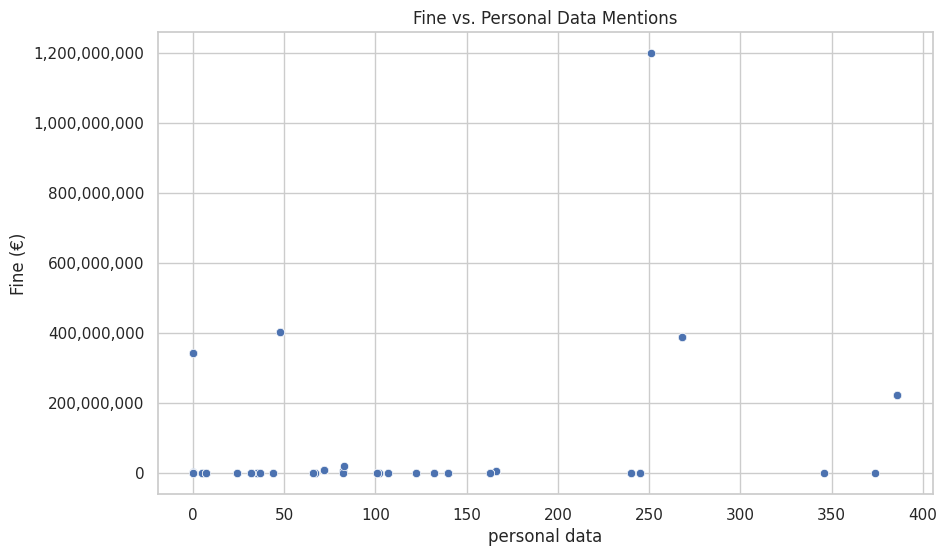

In [48]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='personal data', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Personal Data Mentions')
plt.show()

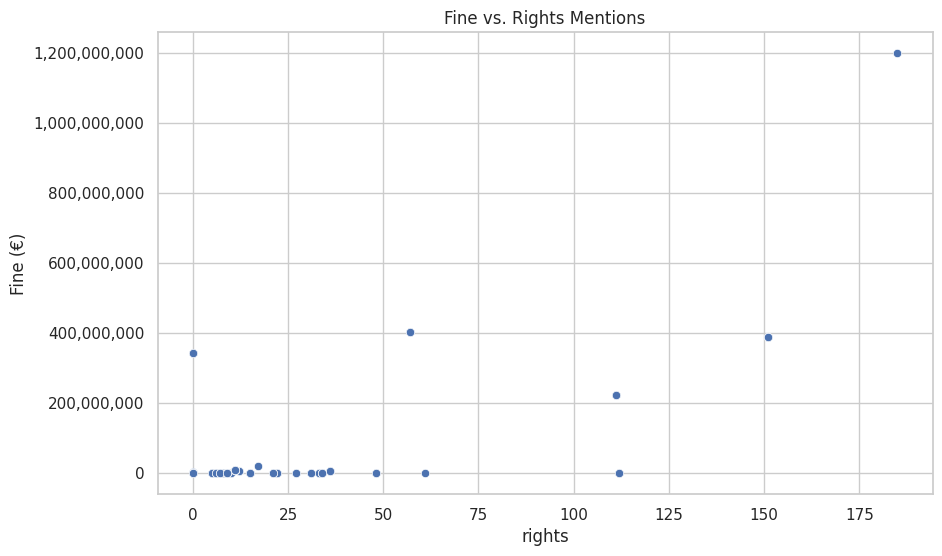

In [49]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='rights', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Rights Mentions')
plt.show()

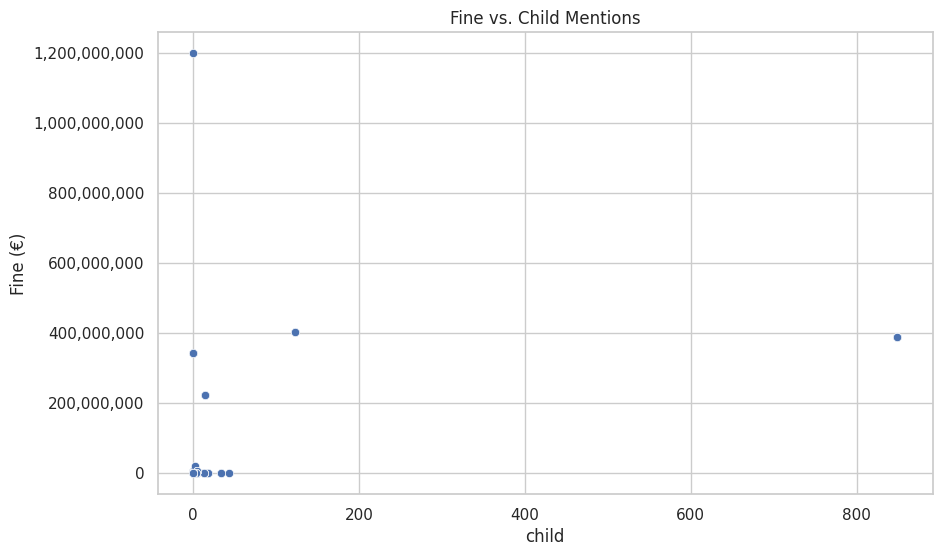

In [50]:
plt.figure(figsize=(10, 6))
# Create the scatter plot with Seaborn
scatter_plot = sns.scatterplot(data=merged_df, x='child', y='Fine [€]')

# Format y-axis labels to display full numbers instead of scientific notation
scatter_plot.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

# Add a y-axis label
plt.ylabel('Fine (€)')

plt.title('Fine vs. Child Mentions')
plt.show()

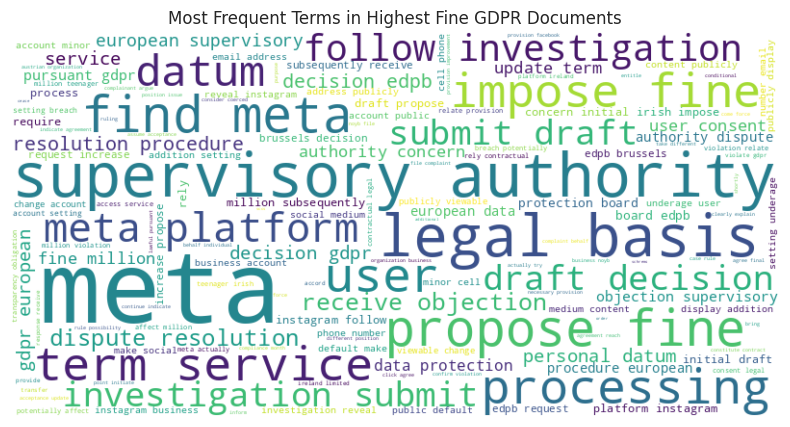

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 1. Filter for highest fines
# Assuming 'merged_df' contains your fine and text data
highest_fines_df = merged_df.nlargest(10, 'Fine [€]') # Select top 10 based on Fine column

# 2. Combine text from highest fine documents
text_string = " ".join(highest_fines_df['Summary'].astype(str).tolist()) # Assuming 'Text' column holds the text

# 3. Preprocess text (clean, tokenize, etc.) if not already done
# This step is important to remove irrelevant words (stop words, punctuation) and improve visualization
# You might have functions like 'clean_text' from earlier parts of the code

cleaned_text = clean_text(text_string)  # Example assuming 'clean_text' function is available
text_string = " ".join(cleaned_text)

# 4. Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in Highest Fine GDPR Documents")
plt.show()

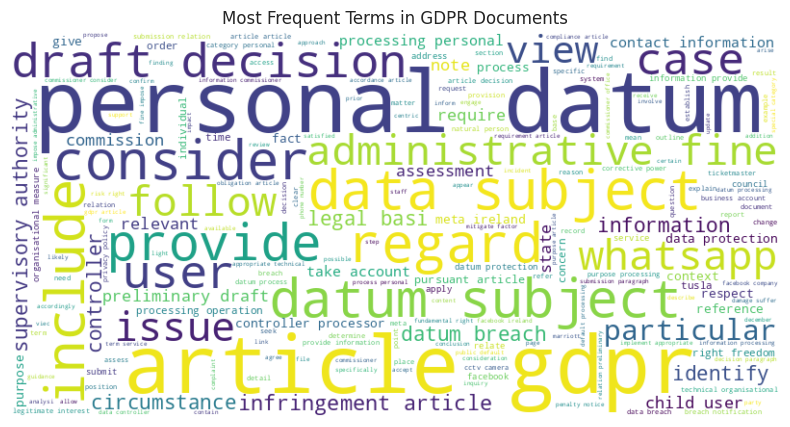

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming `cleaned_text` contains your preprocessed text (no stopwords, lowercased, lemmatized)
# Correctly apply clean_text to each text in the texts dictionary
cleaned_texts = [clean_text(text) for text in texts.values()]
text_string = " ".join([" ".join(cleaned_text) for cleaned_text in cleaned_texts ])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most Frequent Terms in GDPR Documents")
plt.show()

In [7]:
def plot_coherence_vs_topics(texts, start=2, limit=20, step=2):
    tokenized_docs = [clean_text(text) for text in texts.values()]
    dictionary = corpora.Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    coherences = []
    topic_range = range(start, limit, step)

    for num_topics in topic_range:
        model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary,
                                passes=20, alpha='symmetric', eta='auto', random_state=42)
        coherence = CoherenceModel(model=model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v').get_coherence()
        coherences.append(coherence)

    plt.figure(figsize=(8, 5))
    plt.plot(topic_range, coherences, marker='o')
    plt.title('Coherence Score vs Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid(True)
    plt.show()

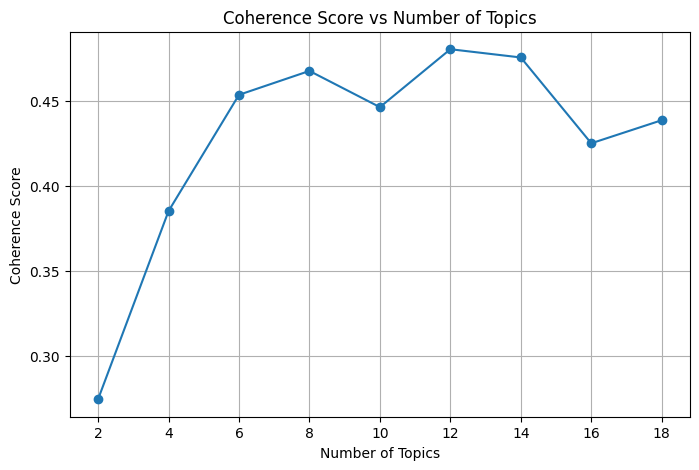

In [8]:
plot_coherence_vs_topics(texts)

In [19]:
# 🧠 LDA Topic Modeling Function

def perform_topic_modeling(texts, num_topics=12, passes=30):
    tokenized_docs = [clean_text(text) for text in texts.values()]
    dictionary = corpora.Dictionary(tokenized_docs)
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        passes=passes,
        alpha='asymmetric',
        eta='auto',
        random_state=42
    )

    coherence_model = CoherenceModel(model=lda_model, texts=tokenized_docs, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    print(f"Coherence Score: {coherence_score:.4f}")
    for idx, topic in lda_model.print_topics():
        print(f"Topic {idx}: {topic}")

    return lda_model, corpus, dictionary, tokenized_docs


In [20]:
lda_model, corpus, dictionary, tokenized_docs = perform_topic_modeling(texts)

Coherence Score: 0.4898
Topic 0: 0.097*"council" + 0.060*"camera" + 0.034*"garda" + 0.023*"traffic" + 0.022*"officer" + 0.022*"management" + 0.020*"centre" + 0.018*"monitoring" + 0.017*"síochána" + 0.016*"inquiry"
Topic 1: 0.096*"meta" + 0.068*"edpb" + 0.035*"objection" + 0.022*"cjeu" + 0.012*"charter" + 0.011*"bind" + 0.011*"country" + 0.011*"fundamental" + 0.010*"clause" + 0.010*"derogation"
Topic 2: 0.041*"inquiry" + 0.023*"department" + 0.012*"child" + 0.010*"template" + 0.009*"paper" + 0.009*"advice" + 0.009*"officer" + 0.009*"recipient" + 0.008*"management" + 0.008*"unit"
Topic 3: 0.075*"facebook" + 0.042*"complainant" + 0.028*"contract" + 0.024*"argument" + 0.022*"consent" + 0.017*"partly" + 0.017*"compare" + 0.016*"accurately" + 0.016*"product" + 0.013*"argue"
Topic 4: 0.036*"representation" + 0.024*"attack" + 0.022*"para" + 0.015*"server" + 0.014*"attacker" + 0.010*"cyber" + 0.009*"management" + 0.007*"patch" + 0.007*"backup" + 0.007*"appendix"
Topic 5: 0.023*"database" + 0.01

In [33]:
# 🧠 4. Topic modeling (LDA)
def perform_topic_modeling(texts, num_topics=8):
    tokenized_docs = [clean_text(text) for text in texts.values()]
    dictionary = corpora.Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(text) for text in tokenized_docs]
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=10)
    return lda_model.print_topics(), lda_model, corpus, dictionary

topics, lda_model, corpus, dictionary = perform_topic_modeling(texts)
for i, topic in topics:
    print(f"Topic {i}: {topic}")


Topic 0: 0.034*"clearview" + 0.024*"gdpr" + 0.022*"datum" + 0.019*"image" + 0.018*"processing" + 0.017*"article" + 0.017*"commissioner" + 0.013*"personal" + 0.012*"subject" + 0.011*"database"
Topic 1: 0.029*"council" + 0.025*"cctv" + 0.022*"datum" + 0.021*"camera" + 0.020*"section" + 0.013*"personal" + 0.013*"processing" + 0.012*"article" + 0.011*"garda" + 0.010*"purpose"
Topic 2: 0.042*"easylife" + 0.023*"commissioner" + 0.012*"datum" + 0.011*"information" + 0.010*"health" + 0.009*"individual" + 0.008*"office" + 0.008*"product" + 0.007*"penalty" + 0.007*"article"
Topic 3: 0.028*"breach" + 0.026*"article" + 0.016*"controller" + 0.015*"datum" + 0.014*"submission" + 0.011*"personal" + 0.010*"notification" + 0.010*"draft" + 0.009*"council" + 0.009*"gdpr"
Topic 4: 0.023*"article" + 0.022*"meta" + 0.021*"gdpr" + 0.019*"datum" + 0.013*"decision" + 0.013*"edpb" + 0.012*"transfer" + 0.012*"ireland" + 0.010*"data" + 0.010*"paragraph"
Topic 5: 0.030*"datum" + 0.020*"personal" + 0.016*"article" +

In [68]:
# 📌 5. Named Entity Recognition (NER)
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents if ent.label_ in ['ORG', 'GPE', 'MONEY']]

for filename, text in texts.items():
    entities = extract_entities(text)
    top_entities = pd.Series([ent[0] for ent in entities]).value_counts().head(20)
    print(f"\n📄 {filename} → {top_entities.to_dict()}")



📄 ETid-1578.pdf → {'WhatsApp': 413, 'Commission': 275, 'Complaint': 118, 'GDPR': 94, 'EU': 68, 'WhatsApp IE': 44, 'the Terms of Service': 41, 'Terms of Service': 27, 'Inquiry': 23, 'WhatsApp IE’s': 17, 'the WhatsApp Transparency Decision': 13, 'Ireland': 12, 'inter alia': 12, 'CJEU': 11, 'the IE SA': 10, 'the Final Submissions': 10, 'EDPB': 10, 'Default': 9, 'the Final Inquiry Report': 9, 'WhatsApp Ireland Limited': 8}

📄 ETid-893.pdf → {'GDPR': 2, 'SD Cards': 2, 'the Data Protection  Act 2018  \n \n \nInquiry': 1, 'Ireland': 1, 'MOVE': 1, 'the SD Cards': 1, '1,500': 1}

📄 ETid-1965.pdf → {'DOH': 421, 'Department': 76, 'HSE': 72, 'GDPR': 33, 'EU': 23, 'CJEU': 20, 'Inquiry': 18, 'the Department of Health': 12, 'the Temporal Scope': 11, 'DPC': 9, 'DOE': 9, 'State': 9, 'Articles 5(1)(c': 9, 'Categories A': 8, 'Union': 8, 'LPP': 8, 'CSSO': 6, 'SEN': 6, 'the \nDepartment': 5, 'CFR': 5}

📄 ETid-2032.pdf → {}

📄 ETid-1461.pdf → {'GDPR': 30, 'Incident': 17, 'DPA': 14, 'RAP': 13, 'Tribunal': 1

In [10]:
def get_entities_to_remove(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'GPE']]

def remove_entities(text, entities):
    # Soft spacing around entities to avoid word merging
    for ent in entities:
        text = text.replace(ent, ' ' + ent + ' ')
    # Clean removal with regex
    for ent in entities:
        pattern = r'\b' + re.escape(ent) + r'\b'
        text = re.sub(pattern, '', text)
    return text

def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()

# Apply to all documents
cleaned_texts = {}
for filename, text in texts.items():
    entities = get_entities_to_remove(text)
    cleaned = remove_entities(text, entities)
    cleaned = normalize_whitespace(cleaned)
    cleaned_texts[filename] = cleaned


In [14]:
# 📌 Modified NER Function: Return only entities to remove

def get_entities_to_remove(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ['ORG', 'GPE']]

# 📌 Remove NER entities from text
def remove_entities(text, entities):
    for ent in entities:
        text = text.replace(ent, '')
    return text

# 📌 Process all documents
cleaned_texts = {}
for filename, text in texts.items():
    entities_to_remove = get_entities_to_remove(text)
    cleaned = remove_entities(text, entities_to_remove)
    cleaned_texts[filename] = cleaned

In [15]:
def normalize_whitespace(text):
    return re.sub(r'\s+', ' ', text).strip()


In [16]:

# Apply it to each cleaned text
for filename in cleaned_texts:
    cleaned_texts[filename] = normalize_whitespace(cleaned_texts[filename])

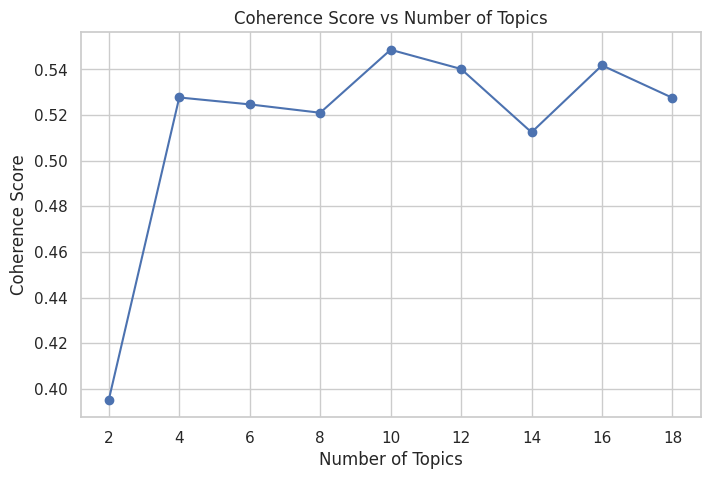

In [55]:
plot_coherence_vs_topics(cleaned_texts)

In [56]:
lda_model_cleaned, corpus_cleaned, dictionary_cleaned, tokenized_docs_cleaned = perform_topic_modeling(cleaned_texts,10,40)

Coherence Score: 0.5624
Topic 0: 0.159*"icle" + 0.067*"objection" + 0.024*"urity" + 0.024*"child" + 0.015*"accot" + 0.014*"legitimate" + 0.011*"fundamental" + 0.010*"alert" + 0.010*"ssion" + 0.010*"default"
Topic 1: 0.083*"child" + 0.026*"default" + 0.023*"roller" + 0.017*"phone" + 0.014*"profile" + 0.012*"publication" + 0.011*"september" + 0.010*"private" + 0.009*"switch" + 0.008*"tion"
Topic 2: 0.032*"ract" + 0.029*"argument" + 0.025*"consent" + 0.020*"roller" + 0.019*"complainant" + 0.019*"partly" + 0.015*"argue" + 0.014*"product" + 0.014*"ibid" + 0.013*"transparency"
Topic 3: 0.101*"commissioner" + 0.015*"june" + 0.012*"payment" + 0.012*"customer" + 0.011*"contravention" + 0.011*"attack" + 0.010*"monetary" + 0.009*"training" + 0.009*"representation" + 0.008*"malicious"
Topic 4: 0.032*"contract" + 0.025*"representative" + 0.017*"dision" + 0.016*"consent" + 0.015*"transparency" + 0.014*"inquiry" + 0.013*"position" + 0.013*"theore" + 0.012*"complaint" + 0.011*"urity"
Topic 5: 0.052*"g

In [65]:
for i, topic in lda_model_cleaned.print_topics():
    print(f"Topic {i}: {topic}")

Topic 0: 0.041*"child" + 0.017*"roller" + 0.014*"default" + 0.011*"transparency" + 0.011*"consent" + 0.009*"phone" + 0.009*"argument" + 0.008*"contract" + 0.008*"ract" + 0.007*"profile"
Topic 1: 0.102*"icle" + 0.053*"objection" + 0.024*"accot" + 0.021*"urity" + 0.017*"child" + 0.014*"database" + 0.012*"cision" + 0.011*"alert" + 0.011*"testing" + 0.010*"legitimate"
Topic 2: 0.074*"rovide" + 0.037*"rocesse" + 0.035*"rocessing" + 0.032*"urose" + 0.024*"ssion" + 0.020*"erence" + 0.019*"tion" + 0.017*"accot" + 0.017*"hone" + 0.015*"oeration"
Topic 3: 0.033*"erson" + 0.026*"rovide" + 0.025*"ersonal" + 0.024*"rotection" + 0.017*"aroriate" + 0.015*"rocessing" + 0.013*"urose" + 0.013*"rocesse" + 0.013*"imose" + 0.012*"charter"
Topic 4: 0.034*"para" + 0.029*"customer" + 0.020*"database" + 0.019*"payment" + 0.018*"image" + 0.018*"card" + 0.013*"approach" + 0.011*"attack" + 0.009*"monitoring" + 0.008*"table"
Topic 5: 0.052*"commissioner" + 0.011*"june" + 0.010*"release" + 0.010*"subje" + 0.009*"at

In [70]:
import glob

# Adjust the folder path as needed
pdf_folder = "gdpr_pdfs"  # Update this!
pdf_files = glob.glob(os.path.join(pdf_folder, "*.pdf"))

In [71]:
# Assign dominant topic to each document
dominant_topics = []
filenames = list(texts.keys())  # assuming 'texts' is a dict {filename: text}

for i, bow in enumerate(corpus_cleaned):
    topic_dist = lda_model_cleaned.get_document_topics(bow)
    top_topic = max(topic_dist, key=lambda x: x[1])  # (topic_id, confidence)
    dominant_topics.append({
        "Filename": os.path.basename(filenames[i]).replace(".pdf", ""),
        "Dominant_Topic": top_topic[0],
        "Topic_Confidence": top_topic[1]
    })

# Convert to DataFrame
doc_topics_df = pd.DataFrame(dominant_topics)
doc_topics_df.set_index("Filename", inplace=True)

# Show result
print(doc_topics_df)
doc_topics_df.to_csv('doc_topics.csv')

           Dominant_Topic  Topic_Confidence
Filename                                   
ETid-2317               3              1.00
ETid-893                5              0.46
ETid-875                2              1.00
ETid-1250               3              1.00
ETid-1009               5              1.00
ETid-1422               3              0.94
ETid-1543               1              1.00
ETid-2566               3              0.52
ETid-847                0              0.20
ETid-570                8              0.78
ETid-1696               0              0.20
ETid-1352               0              0.20
ETid-1666               9              1.00
ETid-2555               7              1.00
ETid-318                0              0.20
ETid-1965               8              0.92
ETid-930                3              1.00
ETid-1578               4              1.00
ETid-2561               0              0.20
ETid-1844               8              0.98
ETid-752                3       

In [72]:
merged = doc_topics_df.merge(metadata_df_cleaned, left_index=True, right_on='ETid', how='left')
merged.head()


,Dominant_Topic,Topic_Confidence,ETid,Country,Authority,Date of Decision,Fine [€],Controller/Processor,Sector,Quoted Art.,Type,Summary
3,3,1.00,ETid-2317,UNITED KINGDOM,Information Commissioner (ICO),2024-04-30 00:00:00,8700,Central Young Men’s Christian Association,Individuals and Private Associations,"[5 (1) f) GDPR, 32 (1), (2) GDPR]",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Central Young M...
37,5,0.46,ETid-893,IRELAND,Data Protection Authority of Ireland,2021-08-20 00:00:00,1500,MOVE Ireland,Individuals and Private Associations,"[5 (1) f) GDPR, 32 (1) GDPR]",Insufficient technical and organisational meas...,The Irish DPA (DPC) has fined the organization...
38,2,1.00,ETid-875,IRELAND,Data Protection Authority of Ireland,2021-10-06 00:00:00,0,Facebook Ireland Limited,"Media, Telecoms and Broadcasting","[5 (1) a) GDPR, 12 (1) GDPR, 13 (1) c) GDPR]",Insufficient fulfilment of information obligat...,The organization 'None of your business' (NOYB...
8,3,1.00,ETid-1250,UNITED KINGDOM,Information Commissioner (ICO),2022-06-09 00:00:00,91000,Tavistock & Portman NHS Foundation Trust,Public Sector and Education,"[5 (1) f) GDPR, 32 GDPR]",Insufficient technical and organisational meas...,The UK DPA (ICO) has fined the Tavistock and P...
35,5,1.00,ETid-1009,IRELAND,Data Protection Authority of Ireland,2021-12-09 00:00:00,110000,Limerick City and County Council,Public Sector and Education,"[13 GDPR, 12 GPDR, 15 GDPR]",Insufficient fulfilment of data subjects rights,The Irish DPA has fined Limerick City and Coun...


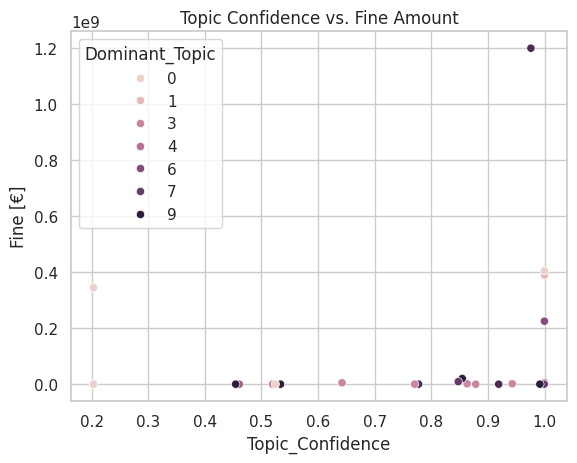

In [73]:
# Assuming 'merged_df' contains your data
sns.scatterplot(data=merged, x='Topic_Confidence', y='Fine [€]', hue='Dominant_Topic')
plt.title('Topic Confidence vs. Fine Amount')
plt.show()

<ipython-input-74-0fb93372d7b6>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Dominant_Topic', y='Fine [€]', palette='viridis')
<ipython-input-74-0fb93372d7b6>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged, x='Dominant_Topic', palette='Set2')


Text(0.5, 0, 'Dominant Topic')

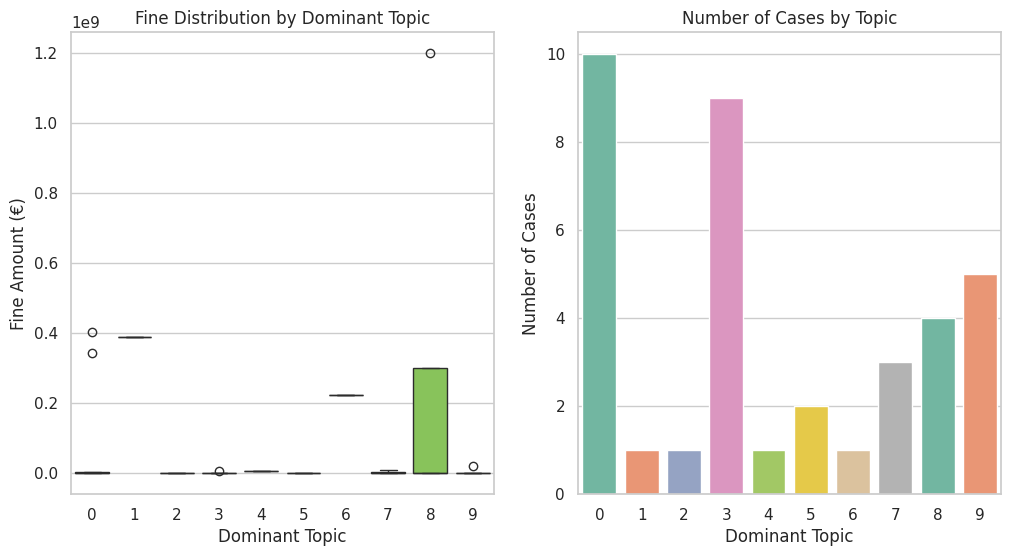

In [74]:
# Create visualizations
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Plot 1: Fine Amounts by Topic
plt.subplot(1, 2, 1)
sns.boxplot(data=merged, x='Dominant_Topic', y='Fine [€]', palette='viridis')
plt.title("Fine Distribution by Dominant Topic")
plt.ylabel("Fine Amount (€)")
plt.xlabel("Dominant Topic")

# Plot 2: Number of Cases per Topic
plt.subplot(1, 2, 2)
sns.countplot(data=merged, x='Dominant_Topic', palette='Set2')
plt.title("Number of Cases by Topic")
plt.ylabel("Number of Cases")
plt.xlabel("Dominant Topic")

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-75-cccfaf95db3f>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x='Dominant_Topic', y='Log_Fine', palette='coolwarm')
<ipython-input-75-cccfaf95db3f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_fines, x='Dominant_Topic', y='Fine [€]', palette='mako')


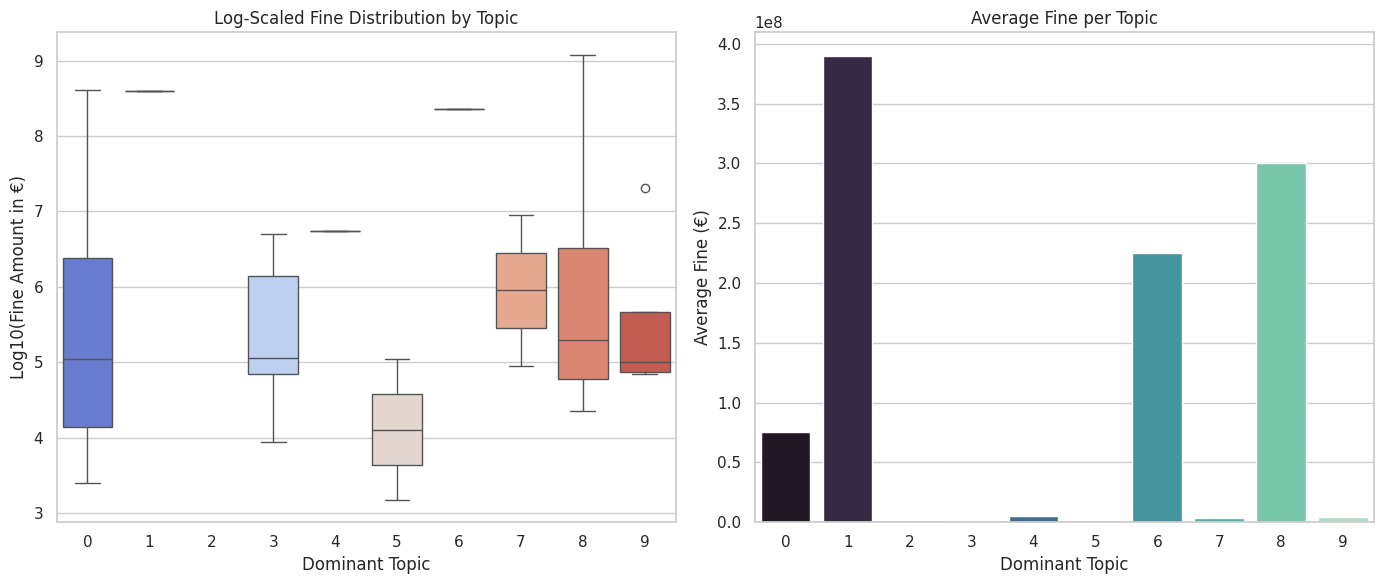

In [75]:
import numpy as np
# Log-transform fine amounts
merged['Log_Fine'] = np.log10(merged['Fine [€]'])

# Set up plots
plt.figure(figsize=(14, 6))

# Boxplot with log-scaled fines
plt.subplot(1, 2, 1)
sns.boxplot(data=merged, x='Dominant_Topic', y='Log_Fine', palette='coolwarm')
plt.title("Log-Scaled Fine Distribution by Topic")
plt.ylabel("Log10(Fine Amount in €)")
plt.xlabel("Dominant Topic")

# Average fine per topic (bar)
plt.subplot(1, 2, 2)
mean_fines = merged.groupby('Dominant_Topic')['Fine [€]'].mean().reset_index()
sns.barplot(data=mean_fines, x='Dominant_Topic', y='Fine [€]', palette='mako')
plt.title("Average Fine per Topic")
plt.ylabel("Average Fine (€)")
plt.xlabel("Dominant Topic")

plt.tight_layout()
plt.show()

In [91]:
import scipy.stats as stats

# Assuming 'confidence_scores' and 'fine_amounts' are arrays
correlation, p_value = stats.pearsonr( merged['Topic_Confidence'], merged['Fine [€]'])
print(f"Correlation: {correlation}, p-value: {p_value}")

Correlation: 0.16615904055956773, p-value: 0.3256711668921621


In [77]:
# Assuming 'merged_df' contains your data
grouped_df = merged.groupby(['Dominant_Topic', pd.cut(merged['Topic_Confidence'], bins=4, )])['Fine [€]'].median()

pd.set_option('display.float_format', '{:.2f}'.format)

print(grouped_df)

Dominant_Topic  Topic_Confidence
0               (0.203, 0.403]        108500.00
                (0.403, 0.602]         60000.00
                (0.602, 0.801]              NaN
                (0.801, 1.0]       405000000.00
1               (0.203, 0.403]              NaN
                (0.403, 0.602]              NaN
                (0.602, 0.801]              NaN
                (0.801, 1.0]       390000000.00
2               (0.203, 0.403]              NaN
                (0.403, 0.602]              NaN
                (0.602, 0.801]              NaN
                (0.801, 1.0]               0.00
3               (0.203, 0.403]              NaN
                (0.403, 0.602]         70300.00
                (0.602, 0.801]       2574000.00
                (0.801, 1.0]          338000.00
4               (0.203, 0.403]              NaN
                (0.403, 0.602]              NaN
                (0.602, 0.801]              NaN
                (0.801, 1.0]         5500000.00
5      

<ipython-input-77-937e3c42a391>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_df = merged.groupby(['Dominant_Topic', pd.cut(merged['Topic_Confidence'], bins=4, )])['Fine [€]'].median()


In [78]:
import numpy as np

class RandomTopicModel:
    def __init__(self, num_topics, vocab_size):
        self.num_topics = num_topics
        self.vocab_size = vocab_size

    def get_topics(self):
        # Return a uniform distribution for each topic across all vocab terms
        return np.ones((self.num_topics, self.vocab_size)) / self.vocab_size


In [79]:
random_model = RandomTopicModel(num_topics=lda_model.num_topics, vocab_size=len(dictionary_cleaned))

In [80]:
from gensim.models import CoherenceModel

lda_coherence_model = CoherenceModel(model=lda_model_cleaned, texts=tokenized_docs_cleaned, dictionary=dictionary_cleaned, coherence='c_v')
lda_coherence = lda_coherence_model.get_coherence()

random_coherence_model = CoherenceModel(model=random_model, texts=tokenized_docs_cleaned, dictionary=dictionary_cleaned, coherence='c_v')
random_coherence = random_coherence_model.get_coherence()


LDA Coherence: 0.562356849553064
Random Coherence: 0.5353214488292327


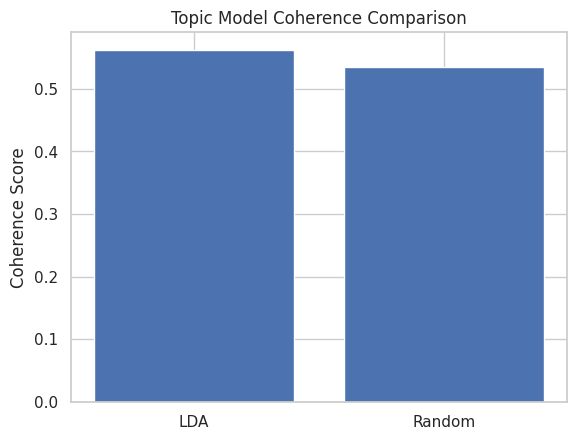

In [81]:
print(f"LDA Coherence: {lda_coherence}")
print(f"Random Coherence: {random_coherence}")

plt.bar(['LDA', 'Random'], [lda_coherence, random_coherence])
plt.title('Topic Model Coherence Comparison')
plt.ylabel('Coherence Score')
plt.show()

In [54]:
print(tokenized_docs[:3])
print(lda_model.print_topics(num_words=5))

[['datum', 'protection', 'section', 'supervisory', 'power', 'information', 'commissioner', 'monetary', 'penalty', 'notice', 'central', 'young', 'christian', 'association', 'central', 'ymca', 'great', 'russell', 'street', 'london', 'introduction', 'summary', 'information', 'commissioner', 'commissioner', 'decide', 'issue', 'central', 'ymca', 'monetary', 'penalty', 'section', 'datum', 'protection', 'penalty', 'notice', 'impose', 'administrative', 'fine', 'central', 'ymca', 'accordance', 'commissioner', 'power', 'article', 'general', 'data', 'protection', 'regulation', 'gdpr', 'penalty', 'seven', 'thousand', 'pound', 'penalty', 'relation', 'contravention', 'article', 'gdpr', 'incident', 'october', 'relevant', 'date', 'affect', 'personal', 'datum', 'process', 'central', 'ymca', 'relevant', 'date', 'reason', 'monetary', 'penalty', 'notice', 'commissioner', 'find', 'central', 'ymca', 'fail', 'ensure', 'appropriate', 'security', 'personal', 'datum', 'control', 'implement', 'appropriate', 'tec

In [82]:
def visualize_topics(lda_model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
    return vis  # Use pyLDAvis.display(vis) or pyLDAvis.save_html(vis, 'lda.html')

In [83]:
visualize_topics(lda_model_cleaned, corpus_cleaned, dictionary_cleaned)

PreparedData(topic_coordinates=          x     y  topics  cluster  Freq
topic                                   
8      0.24 -0.08       1        1 27.25
1     -0.05  0.13       2        1 12.38
6      0.34 -0.04       3        1 12.13
9     -0.13 -0.10       4        1 10.38
3     -0.15 -0.17       5        1  9.24
0     -0.03  0.18       6        1  6.29
4     -0.02  0.12       7        1  6.00
2     -0.06  0.15       8        1  5.73
7     -0.11 -0.14       9        1  5.52
5     -0.03 -0.05      10        1  5.07, topic_info=              Term    Freq   Total Category  logprob  loglift
645           icle  910.00  910.00  Default    30.00    30.00
39    commissioner  819.00  819.00  Default    29.00    29.00
930         rovide 1503.00 1503.00  Default    28.00    28.00
254          child 1066.00 1066.00  Default    27.00    27.00
1510       ersonal  951.00  951.00  Default    26.00    26.00
...            ...     ...     ...      ...      ...      ...
525         easily   25.02   75.81  Topic10    -5.18     1.87
1262        fction   25.72   81.04  Topic10    -5.15     1.83
1007    technology   22.33   87.60  Topic10    -5.30     1.61
819         permit   20.70   71.47  Topic10    -5.37     1.74
644           ibid   20.99  270.64  Topic10    -5.36     0.42

[564 rows x 6 columns], token_table=      Topic  Freq        Term
term                         
281       1  0.18  accessible
281       4  0.05  accessible
281       5  0.31  accessible
281       7  0.04  accessible
281       8  0.09  accessible
...     ...   ...         ...
1080      8  0.07  wrongdoing
1080     10  0.07  wrongdoing
1412      6  0.17        xiii
1412      9  0.52        xiii
1412     10  0.17        xiii

[2187 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 7, 10, 4, 1, 5, 3, 8, 6])